In [1]:
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

import xarray as xr

from dataset.data.common import  CreateListOfLinkfilesInSpan

In [2]:
def extractGPMtime(dataset, attrstr):
    t_str = dataset.attrs['gpm_time_'+attrstr]
    t_dt = datetime.datetime.strptime(t_str if len(t_str)==26 else t_str+'.000000', '%Y-%m-%d %H:%M:%S.%f')
    
    return(t_dt)

def extractGOEStime(dataset, attrstr, ind):
    t_str = dataset.attrs['goes_time_'+attrstr][ind]
    t_dt = datetime.datetime.strptime(t_str if len(t_str)==26 else t_str+'.000000', '%Y-%m-%d %H:%M:%S.%f')
    
    return(t_dt)

def midTime(t_in, t_out):
    mid = t_in + datetime.timedelta(seconds=(t_out-t_in).total_seconds()/2)
    return(mid)

def timeDiff(t2, t1):
    time_diff = (t2-t1).total_seconds()
    return(time_diff)

In [3]:
num_goes = 8

In [4]:
linkdirs = CreateListOfLinkfilesInSpan(17, 12, 18, 1)
parentdirs = ['dataset/origin/' + linkdir + '/' for linkdir in linkdirs]

linkfile2017-12
12
linkfile2018-01
1


In [5]:
file_list = []
gpm_len = []
goes_len_mean = []
goes_len_std = []
max_time_diffs = []

for parentdir in parentdirs:
    for path, subdir, files in os.walk(parentdir):
        for file in files:    
            if file.endswith('.nc'):
                file_list.append(os.path.join(path,file))
                dataset = xr.open_dataset(os.path.join(path,file))
                dataset.close()

                gpm_in = extractGPMtime(dataset, 'in')
                gpm_out = extractGPMtime(dataset, 'out')

                goes_ins = [extractGOEStime(dataset, 'in', i) for i in range(num_goes)]
                goes_outs = [extractGOEStime(dataset, 'out', i) for i in range(num_goes)]

                gpm_len.append(timeDiff(gpm_out,gpm_in))
                goes_diff = [timeDiff(goes_out,goes_in) for goes_in, goes_out in zip(goes_ins, goes_outs)]
                goes_len_mean.append(np.mean(goes_diff))
                goes_len_std.append(np.std(goes_diff))

                gpm_mid = midTime(gpm_in, gpm_out)
                goes_mids = [midTime(goes_in, goes_out) for goes_in, goes_out in zip(goes_ins, goes_outs)]

                time_diff = [timeDiff(gpm_mid, goes_mid) for goes_mid in goes_mids]
                maxabsind = np.argmax(np.abs(np.array(time_diff)))
                max_time_diffs.append(time_diff[maxabsind])


[2.8   2.925 3.05  3.175 3.3   3.425 3.55  3.675 3.8  ]
min 2.8699999999999997
max 3.7916666666666665


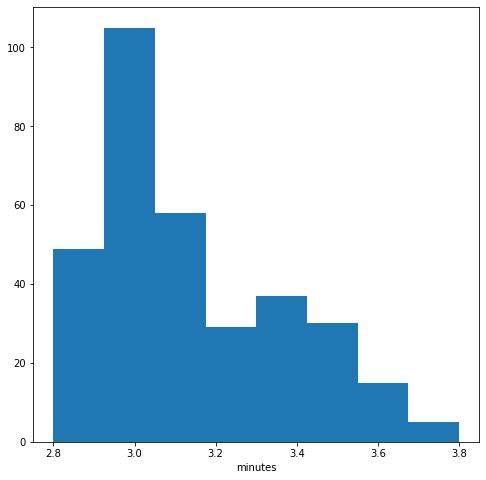

In [6]:
bins = np.linspace(2.8,3.8,9)
print(bins)
gpm_len_arr = np.array(gpm_len)/60
print('min', min(gpm_len_arr))
print('max', max(gpm_len_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(gpm_len_arr, bins=bins)
ax.set_xlabel('minutes')
plt.show()

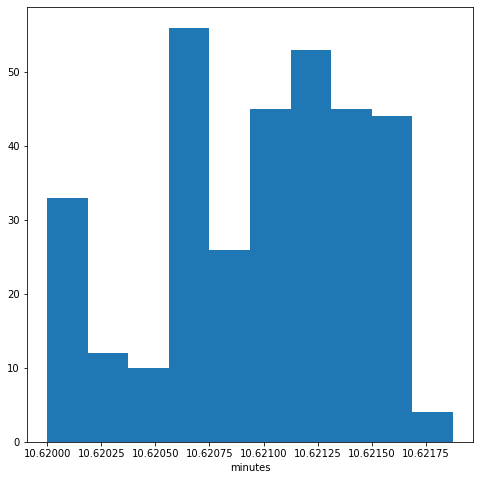

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(np.array(goes_len_mean)/60, bins=10)
ax.set_xlabel('minutes')
plt.show()

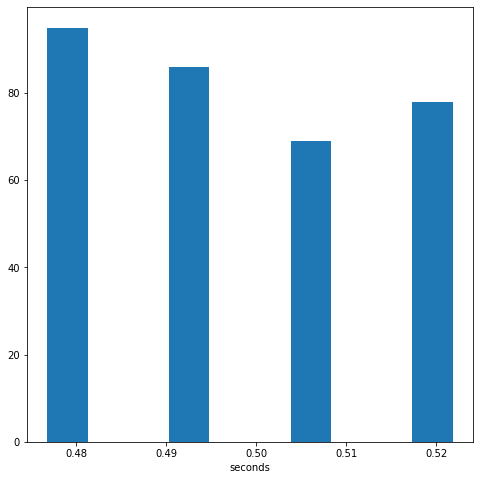

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(np.array(goes_len_std), bins=10)
ax.set_xlabel('seconds')
plt.show()

min -7.126466666666667
max 7.947416649999999


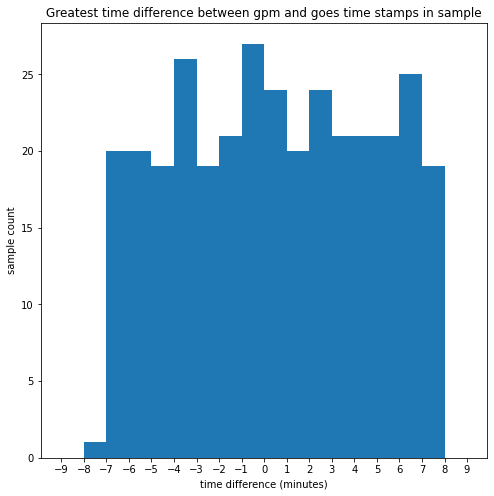

In [9]:
bins = range(-9,10)
max_time_diff_arr = np.array(max_time_diffs)/60
print('min', min(max_time_diff_arr))
print('max', max(max_time_diff_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(max_time_diff_arr, bins=bins)
ax.set_title('Greatest time difference between gpm and goes time stamps in sample')
ax.set_ylabel('sample count')
ax.set_xlabel('time difference (minutes)')
ax.set_xticks(bins)
plt.show()